# Import modules

In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set this to your GPU index if you have multiple

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from gofish import imagecube
from ruamel.yaml import YAML

sys.path.insert(0, '../../')
import visualization, sensor, grid, line_rte, parametric_disk
from network import shard
from consts import *
import emcee
from functools import partial
import time

In [10]:
def render_cube_pinhole(ray_coords, pixel_area, disk_params, nd_co, temperature, velocity_az, bbox, freqs, nu0, obs_dir, molecular_table):
    ray_coords_sph = grid.cartesian_to_spherical(ray_coords)
    ray_coords_polar = grid.spherical_to_zr(ray_coords_sph)

    # Interpolate dataset along the ray coordinates
    gas_nd = grid.interpolate_scalar(nd_co, ray_coords_polar, bbox)
    gas_t  = grid.interpolate_scalar(temperature, ray_coords_polar, bbox, cval=1e-10)
    gas_v_az = grid.interpolate_scalar(velocity_az, ray_coords_polar, bbox)
    gas_v = parametric_disk.azimuthal_velocity(ray_coords, gas_v_az)

    # Load molecular data from disk_params
    energy_levels, radiative_transitions = line_rte.load_molecular_tables(path=molecular_table)
    _, a_ud, b_ud, b_du = line_rte.einstein_coefficients(
        energy_levels, radiative_transitions, transition=disk_params['transition']
    )
    n_up, n_dn = line_rte.n_up_down(
        gas_nd, gas_t, energy_levels, radiative_transitions, transition=disk_params['transition']
    )
    alpha_tot = line_rte.alpha_total_co(disk_params['v_turb'], gas_t)

    print(f'computing pinhole spectral cube for a total of {freqs.size} frequencies')
    print(f'From {freqs.min() / 1e9:3f} GHz to {freqs.max() / 1e9:3f} GHz')
    images = line_rte.compute_spectral_cube_pmap(
        shard(freqs), gas_v, alpha_tot, n_up, n_dn,
        a_ud, b_ud, b_du, ray_coords, obs_dir, nu0, pixel_area
    )
    images = np.nan_to_num(images).reshape(freqs.size, *ray_coords.shape[:2])
    return images

# Load reference data set
This is mainly to get frequencies, pixel size, resolution, and beam size.
Can be substituted with synthetic arrays and values.

Loaded data cube: HD_163296_CO_220GHz.0.2arcsec.image.fits
Data shape: (40, 502, 502)
velocity resolution: 199.99999998061412 m/s


2025-07-03 14:55:18.892196: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


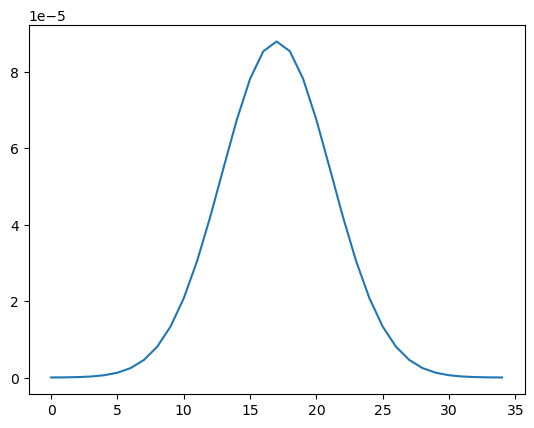

In [3]:
fov_as = 10.0  # arcsecs
data_path = f'/scratch/ondemand28/len/data/radjax/MAPS/HD_163296_CO_220GHz.0.2arcsec.image.fits'
velocity_range = (2000, 10000) # m/s
vlsr = 5770 # systematic velocity of target

print("Loaded data cube:", data_path.split('/')[-1])

data_cube = imagecube(data_path, FOV=fov_as, velocity_range=velocity_range)

freqs = data_cube.velocity_to_restframe_frequency(vlsr=vlsr)
velocities = data_cube.velax
data = data_cube.data

print(f'Data shape: {data.shape}')

x_sky, y_sky = np.meshgrid(data_cube.xaxis, data_cube.yaxis, indexing='xy')
nu0 = data_cube.nu0  # e.g. 230.538 GHz
npix = data_cube.nxpix
width_kms = (velocities[-1] - velocities[0]) / 1000.0
delta_v_ms = velocities[1] - velocities[0]

print(f'velocity resolution: {delta_v_ms} m/s')

beam = data_cube.beams_per_pix * sensor.beam(
    data_cube.dpix, data_cube.bmaj, data_cube.bmin, data_cube.bpa
)

# Show the calculated beam
plt.plot(beam[beam.shape[0]//2]) # Show center slice of beam

# Set up parametric disk parameters

In [7]:
isotope_abundance_factor = 1 # 1 for CO

# Chosen parameters for disk
disk_params = parametric_disk.create_disk_params(
    q=-0.27,
    q_in=-0.57,
    r_break=70,
    log_r_c=2.3,
    v_turb=0.06,
    T_atm1=87.0,
    gamma=1.0,
    T_mid1=17.8,
    M_star=2.3 * M_sun,
    r_in=11.0,
    M_gas=0.09 * M_sun,
    co_abundance=isotope_abundance_factor*1e-4,
    N_dissoc=0.79 * 1.59e21,
    N_desorp=-np.inf,
    freezeout=19.0,
    r_scale=150.0,
    z_q0=70.0,
    delta=1,
    transition=2,
    m_mol=2.37 * m_h,
)

resolution = 500
z_min, z_max = 0, 200
r_min, r_max = disk_params['r_in'], 800
z_disk, r_disk = jnp.meshgrid(
    jnp.linspace(z_min, z_max, resolution), 
    jnp.linspace(r_min, r_max, resolution), 
    indexing='ij'
)

molecular_table = "../../molecular_tables/molecule_12c16o.inp" # Path to your table might differ

temperature = parametric_disk.temperature_profile(z_disk, r_disk, disk_params)

nd_h2 = parametric_disk.number_density_profile(
    z_disk, 
    r_disk, 
    temperature,
    disk_params['gamma'],
    disk_params['r_in'],
    10 ** disk_params['log_r_c'],
    disk_params['M_gas'],
    disk_params['M_star'],
    disk_params['m_mol']
)

velocity_az = -parametric_disk.velocity_profile( # Note the negative
    z_disk, 
    r_disk, 
    nd_h2, 
    temperature, 
    disk_params
)

N_h2 = parametric_disk.surface_density(z_disk, nd_h2)

abundance_co = parametric_disk.co_abundance_profile(N_h2, temperature, disk_params)
nd_co = abundance_co * nd_h2

# Set up ray tracer

In [8]:
bbox_disk = jnp.array([(au*z_min, au*z_max), (au*r_min, au*r_max)])

projection_pinhole = sensor.PinholeProjection(
    name=f'MAPS_HD163296_CO_Tutorial',
    x_sky=x_sky,
    y_sky=y_sky,
    distance=122.0,
    nray=100,
    incl=47.5,
    phi=0.0,
    posang=312.0,
    z_width=2 * z_max,
    freqs=freqs
)

fov_rad = fov_as * arcsec
fov = 2 * projection_pinhole.distance * pc * np.tan(fov_rad / 2.0)
pixel_area_pinhole = (fov / npix) ** 2

ray_coords_pinhole, obs_dir_pinhole = sensor.pinhole_disk_projection(
    projection_pinhole.x_sky,
    projection_pinhole.y_sky,
    projection_pinhole.distance,
    projection_pinhole.nray,
    projection_pinhole.incl,
    projection_pinhole.phi,
    projection_pinhole.posang,
    projection_pinhole.z_width
)

# Render spectral cube

## Before convolution with beam

In [11]:
images = render_cube_pinhole(
    ray_coords_pinhole,
    pixel_area_pinhole,
    disk_params,
    nd_co,
    temperature,
    velocity_az,  # note sign convention
    bbox_disk,
    freqs=freqs,
    nu0=nu0,
    obs_dir=obs_dir_pinhole,
    molecular_table=molecular_table
)

computing pinhole spectral cube for a total of 40 frequencies
From 230.534855 GHz to 230.540853 GHz


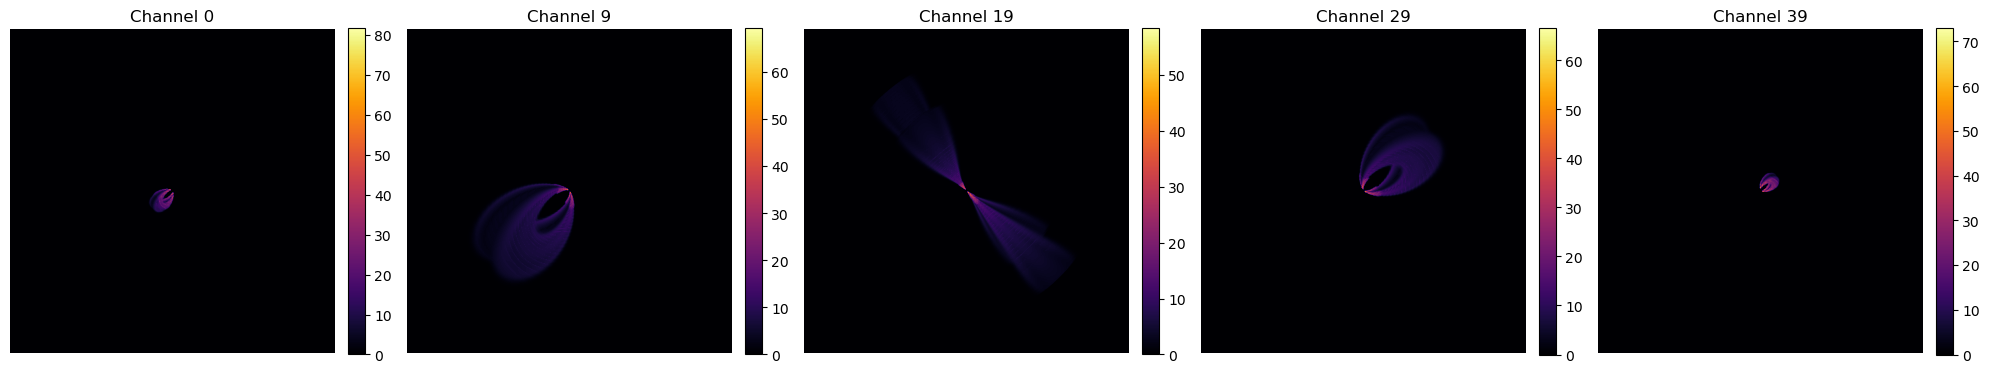

In [12]:
num_slices = 5
channels = images.shape[0]
slice_indices = np.linspace(0, channels - 1, num_slices, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(4 * num_slices, 4))

for i, idx in enumerate(slice_indices):
    im = axes[i].imshow(images[idx], origin='lower', cmap='inferno')
    axes[i].set_title(f"Channel {idx}")
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Beam convolution

In [13]:
images_blurred = sensor.fftconvolve_vmap(images, beam)

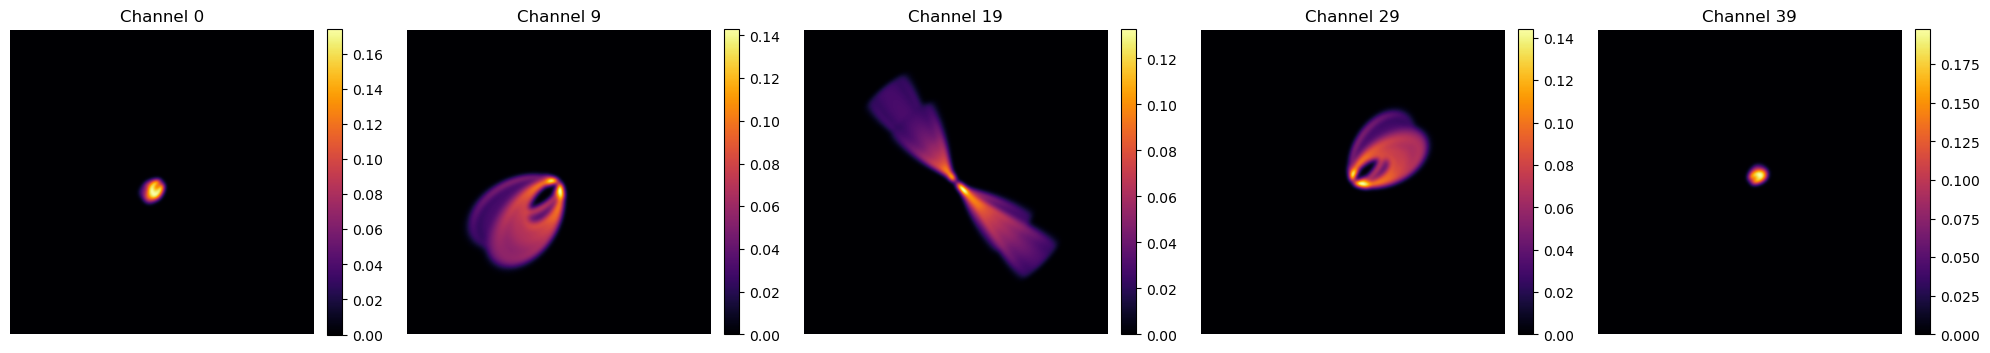

In [14]:
num_slices = 5
channels = images_blurred.shape[0]
slice_indices = np.linspace(0, channels - 1, num_slices, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(4 * num_slices, 4))

for i, idx in enumerate(slice_indices):
    im = axes[i].imshow(images_blurred[idx], origin='lower', cmap='inferno')
    axes[i].set_title(f"Channel {idx}")
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Comparison against data cube

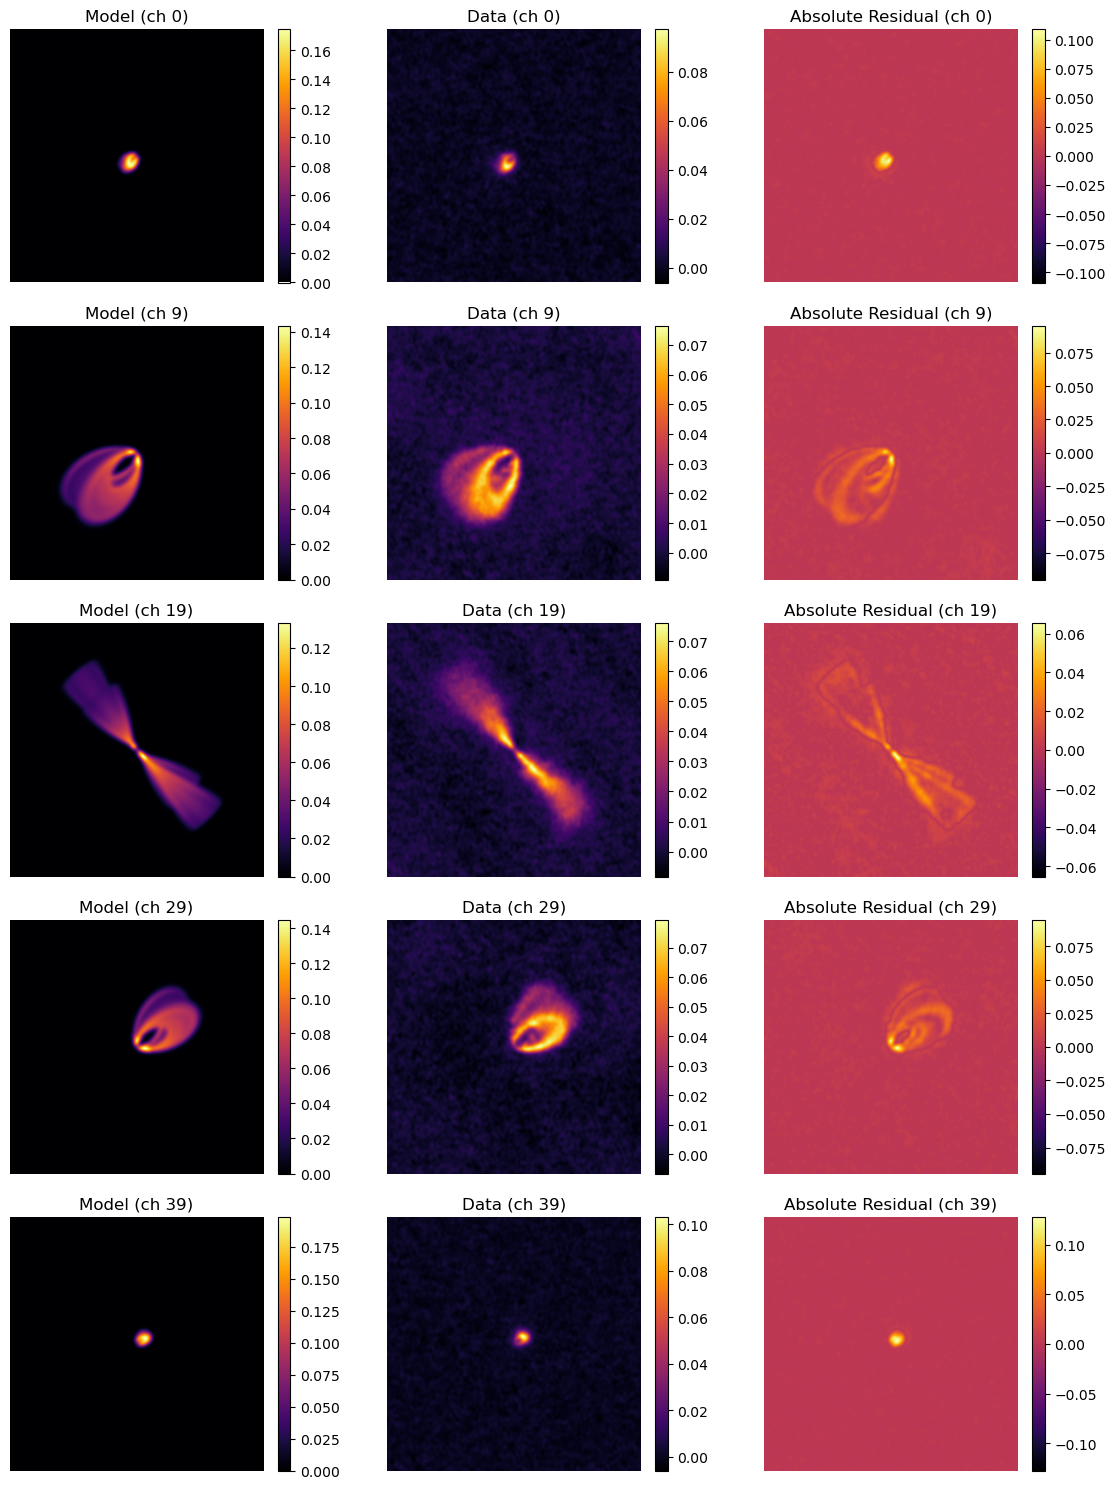

In [22]:
num_slices = 5
channels = images_blurred.shape[0]
slice_indices = np.linspace(0, channels - 1, num_slices, dtype=int)

fig, axes = plt.subplots(num_slices, 3, figsize=(12, 3 * num_slices))

residual = np.abs(data - images_blurred)

for row, idx in enumerate(slice_indices):
    # Model
    im0 = axes[row, 0].imshow(images_blurred[idx], origin='lower', cmap='inferno')
    axes[row, 0].set_title(f"Model (ch {idx})")
    axes[row, 0].axis('off')
    plt.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)

    # Data
    im1 = axes[row, 1].imshow(data[idx], origin='lower', cmap='inferno')
    axes[row, 1].set_title(f"Data (ch {idx})")
    axes[row, 1].axis('off')
    plt.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)

    # Residual
    im2 = axes[row, 2].imshow(residual[idx], origin='lower', cmap='inferno', vmin=-np.max(np.abs(residual[idx])), vmax=np.max(np.abs(residual[idx])))
    axes[row, 2].set_title(f"Absolute Residual (ch {idx})")
    axes[row, 2].axis('off')
    plt.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()